In [1]:
] activate .

  Activating project at `~/devansh/HJB.jl/examples`


In [137]:
] st

Status `~/devansh/HJB.jl/examples/Project.toml`
  [0c46a032] DifferentialEquations v7.12.0
  [a3cb4e6c] HJB v1.0.0-DEV `..`
  [91a5bcdd] Plots v1.40.1
  [49802e3a] ProgressBars v1.5.1
  [295af30f] Revise v3.5.13
  [90137ffa] StaticArrays v1.9.2
  [5d786b92] TerminalLoggers v0.1.7


In [138]:
] precompile 

Precompiling project...
  ✓ Plots → UnitfulExt
  1 dependency successfully precompiled in 38 seconds. 324 already precompiled.


## Import Dependencies

In [139]:
# the first thing to do is to set up the loggers
# for the differential equation solver
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger() )

# now import all the libraries
using Plots, DifferentialEquations, LinearAlgebra, StaticArrays

using HJB

using BenchmarkTools

In [140]:
Threads.nthreads()

16

## Problem: Inverted Pendulum with Boundary on Angles
This one has a stationary pivot point, so its only 2D problem

The dynamics are
$$
    \dot \theta = \omega\\
    \dot \omega = \frac{g}{l} \sin(\theta) + u
$$

Then $\theta=0$ is the (unstable) upright angle that we want to keep the system near, and $u$ is the torque that we can apply. Lets say the torque is bounded to $[-6,6]$, and $g = 9.81$, $l=1.0$

Say the constraint is to keep $\theta \in [-\pi/3, \pi/2]$. 

### Define the Dynamics, and the Hamiltonian

In [216]:
# define the dynamics

function f(x)
    g = 9.81
    l = 1.0
    
    θ = x[1]
    ω = x[2]
    
    return @SVector [ω, g/l * sin(θ)]
end
function g(x)
    return @SMatrix [ [0;;]; [1;;]]
end
function F(t, x, u)
   f(x) + g(x) * u 
end

# define the Hamiltonian
function H(t, x, V, DxV)
    umax = 6.0
    u1 = @SVector [umax]
    u2 = @SVector [-umax]
    H1 = DxV' * F(t, x, u1)
    H2 = DxV' * F(t, x, u2)
    γ = 1.0

    # CBF Hamiltonian!
    return min(0, max(H1, H2) + γ*V)
    # return max(H1, H2) + γ*V
end

function smooth_min(a,  b, k=0.25)
     res = exp2( -a/k ) + exp2( -b/k );
    return -k*log2( res );
end

# define the constraint function
θmin = -π/3
θmax = π/2
function l(x)
   
    ## quadratic cosntraint
    # return (π/3)^2 - x[1]^2    
    
    ## linear (discontinuous constraint)
    # if (x[1] < 0)
    #   return x[1] - θmin
    # else
    #   return θmax -x[1]
    # end
    
    # smooth min constraint
    return smooth_min(x[1] - θmin, θmax - x[1])

end


l (generic function with 1 method)

### Define the Numerical Hamiltonian

In [217]:

# you need to define some dissipation coefficients
# this is a vector of maximum absolute derivatives of H along each spatial dimension
# function dissipation_coefficients(t, x)
#     return @SVector [1.0, 1.0]
# end

function dissipation_coefficients(t, x)
    return @SVector [abs(x[2]), 9.81 + 1.0]
end

numericalHamiltonianMethod = HJB.LocalLaxFriedrichsNHM(
    HJB.LeftWenoGradient(),
    HJB.RightWenoGradient(), 
    dissipation_coefficients
    )

HJB.LocalLaxFriedrichsNHM{HJB.LeftWenoGradient{Float64}, HJB.RightWenoGradient{Float64}, typeof(dissipation_coefficients)}(HJB.LeftWenoGradient{Float64}(1.0e-6), HJB.RightWenoGradient{Float64}(1.0e-6), dissipation_coefficients)

### Create a Grid

In [218]:
x1s = -π:0.05:π
x2s = -3:0.025:3
grid = HJB.Grid((x1s, x2s))

HJB.Grid{2, Float64}((-3.141592653589793, -3.0), (0.05, 0.025), (126, 241), 3)

### Construct the ODE Problem

In [219]:
prob = HJB.get_ODEProblem(H, l, grid, (0.0, -5.0), numericalHamiltonianMethod)

ODEProblem with uType OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}} and tType Float64. In-place: true
timespan: (0.0, -5.0)
u0: 132×247 OffsetArray(::Matrix{Float64}, -3:128, -3:243) with eltype Float64 with indices -3:128×-3:243:
 0.0  0.0  0.0   0.0       0.0      …   0.0       0.0      0.0  0.0  0.0
 0.0  0.0  0.0   0.0       0.0          0.0       0.0      0.0  0.0  0.0
 0.0  0.0  0.0   0.0       0.0          0.0       0.0      0.0  0.0  0.0
 0.0  0.0  0.0  -2.0944   -2.0944      -2.0944   -2.0944   0.0  0.0  0.0
 0.0  0.0  0.0  -2.0444   -2.0444      -2.0444   -2.0444   0.0  0.0  0.0
 0.0  0.0  0.0  -1.9944   -1.9944   …  -1.9944   -1.9944   0.0  0.0  0.0
 0.0  0.0  0.0  -1.9444   -1.9444      -1.9444   -1.9444   0.0  0.0  0.0
 0.0  0.0  0.0  -1.8944   -1.8944      -1.8944   -1.8944   0.0  0.0  0.0
 0.0  0.0  0.0  -1.8444   -1.8444      -1.8444   -1.8444   0.0  0.0  0.0
 0.0  0.0  0.0  -1.7944   -1.7944      -1.7944   -1.7944   0.0  0.0  0.0
 0.0  0.0  0.0  -1.7444   -1.7444

### Plot the Value function at the terminal time
This is just a sanity check

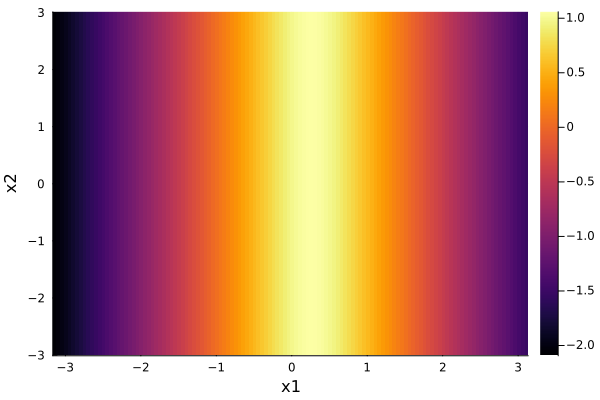

In [220]:
hjb_plot(grid, prob.u0)

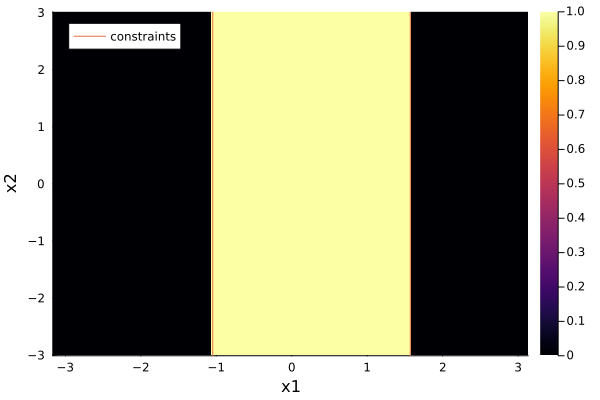

In [221]:
hjb_plot(grid, prob.u0 .>= 0.0)
vline!([θmin, θmax], label="constraints")

### Solve the ODE Problem

In [222]:
# Choose any solver from `DifferentialEquations.jl`. Here are some choices:
#   SSPRK54() # good
#   SSPRK53() # good
#   SSPRK22() # good
#   SSPRK43() # very slow
#   Tsit5() # good
#   unspecified # good

@time sol = solve(prob; reltol=1e-6, abstol=1e-6, progress=true, dt=1e-3, alg=SSPRK53())

ODE   0%|                                               |  ETA: N/A
ODE  20%|█████████▍                                     |  ETA: 0:00:21
ODE  40%|██████████████████▊                            |  ETA: 0:00:16
ODE  60%|████████████████████████████▎                  |  ETA: 0:00:10
ODE  80%|█████████████████████████████████████▋         |  ETA: 0:00:05


 25.578079 seconds (10.22 M allocations: 3.633 GiB, 5.02% gc time, 2.97% compilation time: 6% of which was recompilation)


ODE 100%|███████████████████████████████████████████████| Time: 0:00:25
ODE 100%|███████████████████████████████████████████████| Time: 0:00:25


retcode: Success
Interpolation: 3rd order Hermite
t: 5001-element Vector{Float64}:
  0.0
 -0.001
 -0.002
 -0.003
 -0.004
 -0.005
 -0.006
 -0.007
 -0.008
 -0.009000000000000001
 -0.010000000000000002
 -0.011000000000000003
 -0.012000000000000004
  ⋮
 -4.989000000000001
 -4.990000000000001
 -4.991000000000001
 -4.992000000000002
 -4.993000000000002
 -4.994000000000002
 -4.995000000000003
 -4.996000000000003
 -4.997000000000003
 -4.998000000000004
 -4.999000000000004
 -5.0
u: 5001-element Vector{OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0

### Plot the Solutions

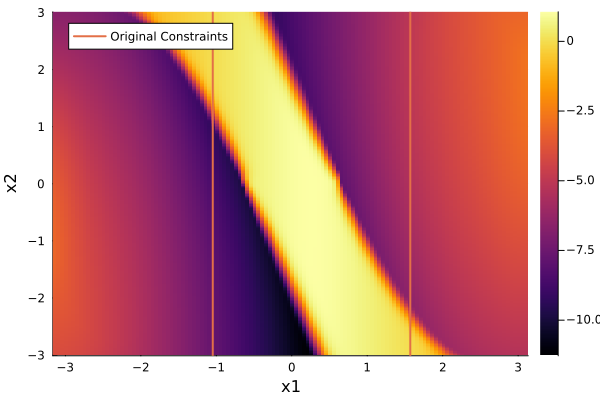

In [223]:
hjb_plot(grid, sol.u[end])
vline!([θmin, θmax], linewidth=2, label="Original Constraints")

[ Info: Saved animation to /home/dasc3/devansh/HJB.jl/examples/tmp.gif


Plots.AnimatedGif("/home/dasc3/devansh/HJB.jl/examples/tmp.gif")
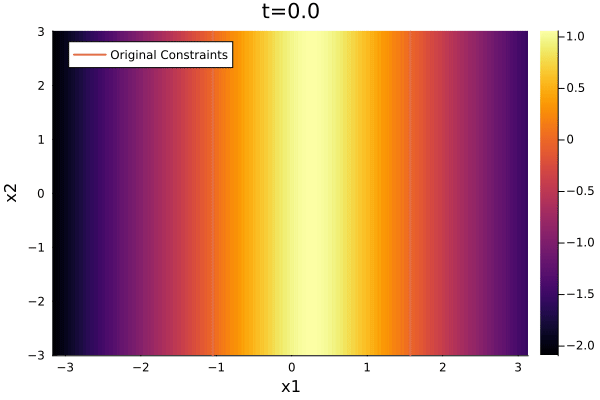

In [224]:
tmin = minimum(sol.t)
tmax = maximum(sol.t)

# i shall animate backwards in time, which should make it easier to see if the solution has converged
@gif for t=range(tmax, tmin, length=30)
    # interpolate the data
    data = sol(t)
    hjb_plot(grid, data)
    vline!([θmin, θmax], linewidth=2, label="Original Constraints")
    title!("t=$(t)")
end

Draw a Level Set

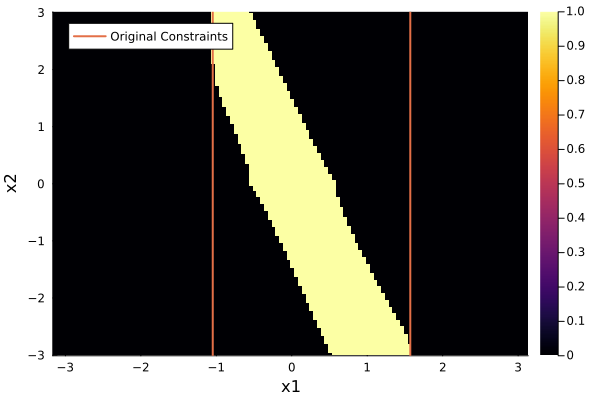

In [225]:
plot()
hjb_plot!(grid, sol.u[end] .>= 0.0)
vline!([θmin, θmax], linewidth=2, label="Original Constraints")

[ Info: Saved animation to /home/dasc3/devansh/HJB.jl/examples/tmp.gif


Plots.AnimatedGif("/home/dasc3/devansh/HJB.jl/examples/tmp.gif")
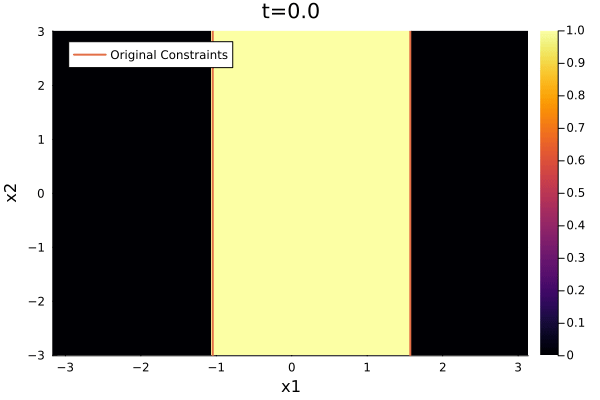

In [226]:
tmin = minimum(sol.t)
tmax = maximum(sol.t)

# i shall animate backwards in time, which should make it easier to see if the solution has converged
@gif for t=range(tmax, tmin, length=30)
    # interpolate the data
    data = sol(t)
    hjb_plot(grid, data .>= 0.0)
    vline!([θmin, θmax], linewidth=2, label="Original Constraints")
    title!("t=$(t)")
end

looks like it has more or less converged

## Test a CBF-QP controller on this Value function

In [227]:
# first we create an interpolator over the data

using Interpolations

xs = HJB.getDomainAxes(grid, 1)
ys = HJB.getDomainAxes(grid, 2)

data = sol.u[end][HJB.DomainIndices(grid)];

itp = interpolate(data, BSpline(Cubic(Line(OnGrid()))))
sitp = scale(itp, (xs, ys))

126×241 scale(interpolate(OffsetArray(::Matrix{Float64}, 0:127, 0:242), BSpline(Cubic(Line(OnGrid())))), (-3.141592653589793:0.05:3.108407346410207, -3.0:0.025:3.0)) with element type Float64:
 -4.0507   -4.03704  -4.02338  -4.00972  …  -6.65084  -6.67917  -6.70738
 -4.07994  -4.06627  -4.0526   -4.03893     -6.65386  -6.6813   -6.70871
 -4.1093   -4.09562  -4.08195  -4.06828     -6.65903  -6.68563  -6.71223
 -4.1392   -4.12552  -4.11185  -4.09818     -6.67068  -6.69654  -6.72241
 -4.17081  -4.15717  -4.14354  -4.12993     -6.69029  -6.71552  -6.74075
 -4.20622  -4.19268  -4.17918  -4.16571  …  -6.71544  -6.74009  -6.76476
 -4.24667  -4.23331  -4.22001  -4.2068      -6.74473  -6.76885  -6.79306
 -4.29245  -4.27937  -4.26637  -4.25351     -6.77876  -6.80255  -6.82647
 -4.34361  -4.3309   -4.31828  -4.30588     -6.81773  -6.84133  -6.86509
 -4.40007  -4.3878   -4.37564  -4.36376     -6.86211  -6.88564  -6.90931
 -4.46166  -4.44988  -4.43822  -4.4269   …  -6.91196  -6.93543  -6.959
 -4.52

In [228]:
# check the interpolation looks reasonable

In [229]:
sitp(0,-3)

-10.62530729182538

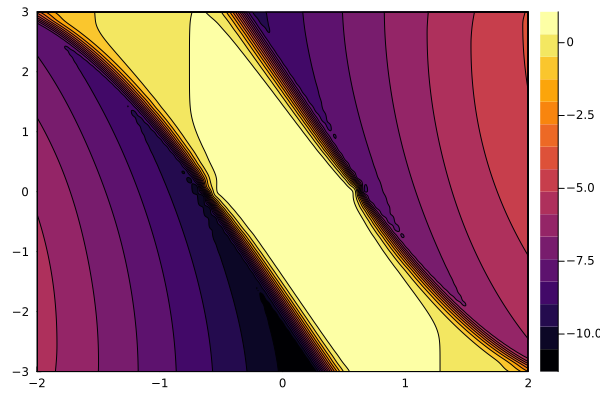

In [230]:
plot()
contourf(-2:0.01:2, -3:0.01:3, (x,y)->sitp(x,y))

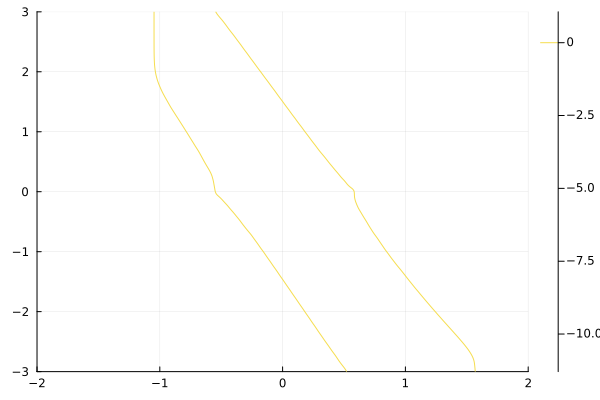

In [231]:
plot()
contour(-2:0.01:2, -3:0.01:3, (x,y)->sitp(x,y), levels=[0.0])

In [232]:
# define the CBF quantities

In [233]:
h(x) = sitp(x...)

h (generic function with 1 method)

In [234]:
∇h(x) = Interpolations.gradient(sitp, x...)

∇h (generic function with 1 method)

In [238]:
Lfh(x) = (∇h(x) )' * f(x)
Lgh(x) = (∇h(x) )' * g(x)

Lgh (generic function with 1 method)

In [239]:
Lfh([0,1.0])

0.05466439893066499

In [240]:
Lgh([0,1.0])

1×1 adjoint(::SVector{1, Float64}) with eltype Float64 with indices SOneTo(1)×SOneTo(1):
 -0.22750227837248427

In [242]:
function qp_controller(x, uref=[0.0])
    h_ = h(x)
    Lfh_ = Lfh(x)
    Lgh_ = Lgh(x)
    γ = 1.0 # same as what is used in the original HJB solver
   
    # just use the closed-form solution of the CBF-QP controller
    if (Lfh_ + Lgh_ * uref >= -γ * h_)
        return uref
    else
        return uref - (Lfh_ + Lgh_ * uref + γ * h_) * Lgh_' / (Lgh_ * Lgh_')
    end
end
    

qp_controller (generic function with 2 methods)

In [250]:
qp_controller([0,1.], [100.0])

1-element SVector{1, Float64} with indices SOneTo(1):
 4.40686916077226

In [283]:
function closed_loop_dynamics(state, params, time)
    
    uref = @SVector [-6.0]
    
    u = qp_controller(state, uref)
    
    xdot = F(time, state, u)
    
end
    

closed_loop_dynamics (generic function with 1 method)

In [284]:
x0 = @SVector [0, 0.5]

2-element SVector{2, Float64} with indices SOneTo(2):
 0.0
 0.5

In [285]:
closed_loop_dynamics(x0, (), 0.0)

2-element SVector{2, Float64} with indices SOneTo(2):
  0.5
 -6.0

In [286]:
dynProb = ODEProblem(closed_loop_dynamics, x0, (0.0, 3.0))

ODEProblem with uType SVector{2, Float64} and tType Float64. In-place: false
timespan: (0.0, 3.0)
u0: 2-element SVector{2, Float64} with indices SOneTo(2):
 0.0
 0.5

In [287]:
dynSol = solve(dynProb)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 26-element Vector{Float64}:
 0.0
 0.001995435672494697
 0.02118180756130532
 0.06826161925659877
 0.13586290074255158
 0.188415962845594
 0.23158711354517383
 0.2547235639148268
 0.2881845609281287
 0.33600486099424676
 0.40510429587807156
 0.4691512235171151
 0.5544205387106134
 0.6576379156018768
 0.7605444797283812
 0.9061619455305912
 1.0186421101142025
 1.1673939106397158
 1.3207128117634657
 1.512907612986005
 1.808818388864939
 2.070315516868904
 2.390128241546145
 2.7017891504095224
 2.918375430361331
 3.0
u: 26-element Vector{SVector{2, Float64}}:
 [0.0, 0.5]
 [0.0009857790021335125, 0.48803707332700713]
 [0.009252173980212875, 0.37391666043354843]
 [0.020359147984529424, 0.09877386036046092]
 [0.01378332960484031, -0.29404707911354455]
 [-0.0098566769575751, -0.6076455830079815]
 [-0.041082765567210314, -0.7863476972120612]
 [-0.05946634819

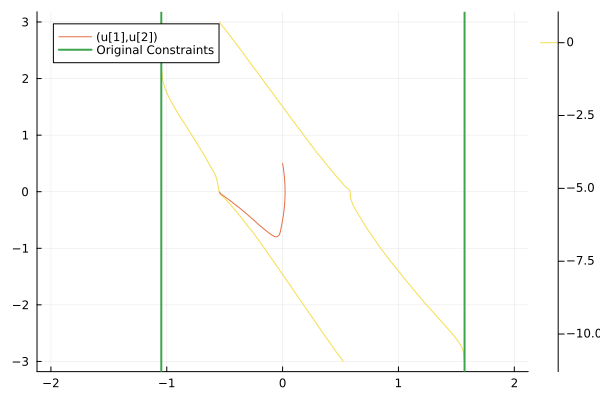

In [288]:
plot()
contour(-2:0.01:2, -3:0.01:3, (x,y)->sitp(x,y), levels=[0.0])
plot!(dynSol, idxs=[(1,2)])
vline!([θmin, θmax], linewidth=2, label="Original Constraints")